In [1]:
%load_ext autoreload
%autoreload 2
!pip install pytorch-lightning==0.7.6 > /dev/null
import pytorch_lightning as pl
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import math
from scipy.integrate import solve_ivp
import time

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
ERROR: Could not find a version that satisfies the requirement pytorch-lightning==0.7.6 (from versions: 0.0.2, 0.5.3, 0.5.3.1)
ERROR: No matching distribution found for pytorch-lightning==0.7.6
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from network import Euler
from Util import *
from DataGenerator import *
from Trainer import *


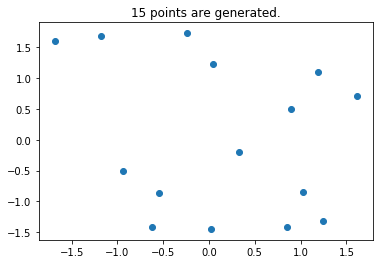

(804) points are generated
(Epoch 1 / 100, seconds: 0) train loss: 0.001905 validation loss: 0.049927
(Epoch 2 / 100, seconds: 0) train loss: 0.001890 validation loss: 0.049498
(Epoch 3 / 100, seconds: 0) train loss: 0.001865 validation loss: 0.048701
(Epoch 4 / 100, seconds: 0) train loss: 0.001816 validation loss: 0.047143
(Epoch 5 / 100, seconds: 0) train loss: 0.001719 validation loss: 0.044076
(Epoch 6 / 100, seconds: 0) train loss: 0.001542 validation loss: 0.038738
(Epoch 7 / 100, seconds: 0) train loss: 0.001294 validation loss: 0.032289
(Epoch 8 / 100, seconds: 0) train loss: 0.001094 validation loss: 0.027815
(Epoch 9 / 100, seconds: 0) train loss: 0.000976 validation loss: 0.024782
(Epoch 10 / 100, seconds: 0) train loss: 0.000863 validation loss: 0.021482
(Epoch 11 / 100, seconds: 0) train loss: 0.000737 validation loss: 0.017639
(Epoch 12 / 100, seconds: 0) train loss: 0.000613 validation loss: 0.013905
(Epoch 13 / 100, seconds: 0) train loss: 0.000520 validation loss: 0.0

In [3]:
# Generate data for spiral function
def vector_field_spiral(t, x):
    v = [-0.1 * x[0] - 0.5 * x[1], 0.5 * x[0] - 0.1 * x[1]]
    return v

# Sample initial points
num_points = 15
x = np.random.uniform(-2, 2, num_points)
y = np.random.uniform(-2, 2, num_points)
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("{} points are generated.".format(num_points))
plt.show()


# Generate Trajectories
duration = 100
DATAPOINTS = None
for i, j in tuple(zip(x, y)):
    trajectory = generate_trajectory_by_ivp([i, j], fun=vector_field_spiral, alpha=None, duration=duration)
    if DATAPOINTS is None:
        DATAPOINTS = trajectory
    else:
        DATAPOINTS = torch.cat([DATAPOINTS, trajectory], dim=0)
print("({}) points are generated".format(len(DATAPOINTS)))

# Train
N = len(DATAPOINTS)  # Size of dataset
M = 2  # input_size
D = 2  # output_size
H = 128  # hidden_size

model = Eueler(input_size=M, output_size=D, hidden_size=H).to(device)
loss_fn = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

np.random.seed(0)
indices = np.random.permutation(N)
train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[
                                                                                            num_train + num_val:]
batch_size = 32
batch_num = np.math.floor(N / batch_size)
batched_train_idxs = np.array_split(train_idx, batch_num)
X = DATAPOINTS[:, :M]
X_1 = DATAPOINTS[:, M:]

epochs = 100

dt = torch.tensor(0.1).to(device).float()
for t in range(epochs):
    train_epoch_loss = 0.0
    seconds = time.time()
    for batch_idx in batched_train_idxs:
        x_0_with_alpha = X[batch_idx].float()
        x_1 = X_1[batch_idx].float()

        y_pred = model(x_0_with_alpha, dt)  # NxM => NxD

        # Compute and print loss.
        loss = loss_fn(y_pred, x_1)
        train_epoch_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    train_epoch_loss /= len(train_idx)
    validation_loss = loss_fn(model(X[val_idx].float(), dt), X_1[val_idx].float())
    print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (
        t + 1, epochs, (time.time() - seconds), train_epoch_loss, validation_loss))


EULER METHOD BY HAND


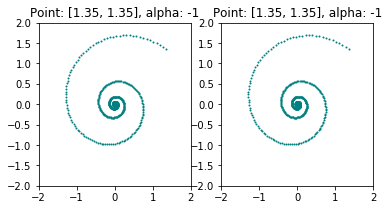

In [4]:
point = [1.35, 1.35]
print("EULER METHOD BY HAND")
trajectory_1 = generate_trajectory_by_euler(fun=vector_field_spiral, start_point=point, alpha=None, duration=100, time_step = 0.1)
visualize_trajectories([trajectory_1,trajectory_1], point, [-1,-1])

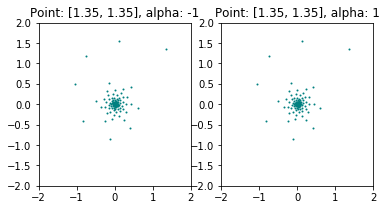

In [15]:
time_step = 0.13
points = np.empty((1, 4))
time = 0
p = np.array(point)

torch_time_step = torch.tensor(time_step).to(device).float()

while time < duration:
    x_1 = model(torch.from_numpy(p.reshape(1, 2)).float(), torch_time_step).detach().numpy()

    row = np.append(p, x_1).reshape(1, 4)

    points = np.vstack((points, row))

    p = x_1
    time += time_step
    
trajectory_1 = torch.from_numpy(points).float()
visualize_trajectories([trajectory_1,trajectory_1], point, [-1,1])